In [1]:
import os
os.chdir('..')
os.getcwd()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import pickle

In [3]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet import OldGraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.evaluation_metrics import get_net_projection, graph_trustworthiness

In [40]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


Node Degree
0 16
1 9
2 10
3 6
4 3
5 4
6 4
7 4
8 5
9 2
10 3
11 1
12 2
13 5
14 2
15 2
16 2
17 2
18 2
19 3
20 2
21 2
22 2
23 5
24 3
25 3
26 2
27 4
28 3
29 4
30 4
31 6
32 12
33 17


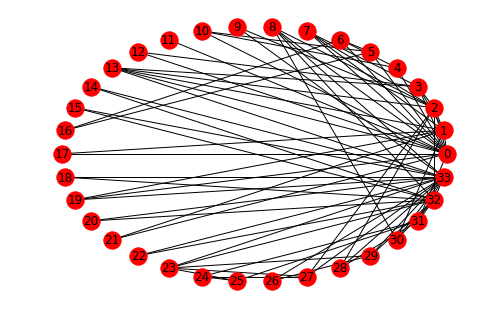

In [4]:
G = nx.karate_club_graph()
print("Node Degree")
for v in G:
    print('%s %s' % (v, G.degree(v)))

nx.draw_circular(G, with_labels=True)

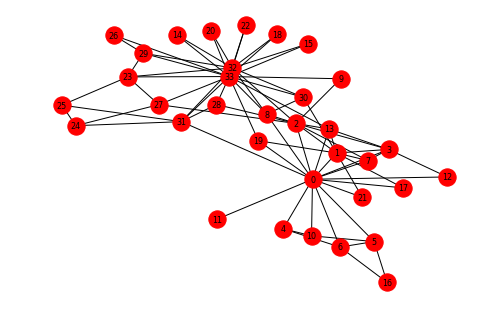

In [5]:
pos = nx.spring_layout(G, scale=2)
nx.draw(G, pos, font_size=8, with_labels=True)

In [6]:
path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [7]:
n = len(path_lengths)
path_matrix = np.array([[path_lengths[i][k] for k in range(n)] for i in range(n)])
path_matrix.shape

(34, 34)

In [8]:
path_matrix

array([[0, 1, 1, ..., 1, 2, 2],
       [1, 0, 1, ..., 2, 2, 2],
       [1, 1, 0, ..., 2, 1, 2],
       ...,
       [1, 2, 2, ..., 0, 1, 1],
       [2, 2, 1, ..., 1, 0, 1],
       [2, 2, 2, ..., 1, 1, 0]])

In [9]:
from sklearn.manifold import TSNE
embedder = TSNE(n_components=2, metric='precomputed', method="exact", perplexity=30, verbose=1)
y_emb = embedder.fit_transform(path_matrix)

[t-SNE] Computed conditional probabilities for sample 34 / 34
[t-SNE] Mean sigma: 1.307157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.721275
[t-SNE] KL divergence after 1000 iterations: 0.392247


In [10]:
A = nx.adjacency_matrix(G)
A = A.toarray()
A

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]], dtype=int64)

In [11]:
from util.plot_graph_embedding import plot_graph_embedding

In [12]:
labels = [1, 1, 2, 1, 0, 0, 0, 1, 3, 2, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3]
print(labels)

[1, 1, 2, 1, 0, 0, 0, 1, 3, 2, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3]


In [13]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [52]:
import scipy.sparse as sp
adj = sp.coo_matrix(A)
plot_graph_embedding(y_emb, np.array(labels), adj)

In [15]:
X = np.eye(n)

In [16]:
print(X.shape)
print(len(labels))
print(A.shape)

(34, 34)
34
(34, 34)


In [26]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = 34 # input dimension
net_parameters['H'] = 4 # number of hidden units
net_parameters['L'] = 2 # number of hidden layers

In [27]:
from core.OldGraphConvNet import OldGraphConvNet
net_1 = OldGraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()

In [28]:
G_all = GraphDataBlock(X, labels, A)

In [29]:
y_pred_1 = get_net_projection([G_all], net_1)

In [30]:
plot_graph_embedding(y_pred_1, np.array(labels), adj)

In [38]:
filename = 'karate.pkl'
with open(filename, 'wb') as f:
    pickle.dump([X, labels, [], A], f)

In [57]:
# Graph net
net_1 = OldGraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/karate_1/'
filename = root + 'graph_net_300.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])
net_1.eval()

OldGraphConvNet(
  (gnn_cells): ModuleList(
    (0): OldGraphConvNetCell(
      (Ui1): Linear(in_features=34, out_features=4, bias=False)
      (Uj1): Linear(in_features=34, out_features=4, bias=False)
      (Vi1): Linear(in_features=34, out_features=4, bias=False)
      (Vj1): Linear(in_features=34, out_features=4, bias=False)
      (Ui2): Linear(in_features=4, out_features=4, bias=False)
      (Uj2): Linear(in_features=4, out_features=4, bias=False)
      (Vi2): Linear(in_features=4, out_features=4, bias=False)
      (Vj2): Linear(in_features=4, out_features=4, bias=False)
      (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=34, out_features=4, bias=False)
    )
  )
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

In [58]:
y_pred_1 = get_net_projection([G_all], net_1)
plot_graph_embedding(y_pred_1, np.array(labels), adj)